# Import Libraries

In [1]:
# Mengunduh lbraries yang dibutuhkan
%pip install transformers
%pip install Sastrawi
%pip install emoji

# Mengunduh / clone repository
!git clone https://github.com/rifqimaruf/indonlu.git

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (500/500), 9.45 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [2]:
# libraries untuk data processing
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import display, HTML
from collections import defaultdict

# Natural Language Processing Libraries
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from collections import defaultdict

# Melakukan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# Melaukan Handling Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler

# Deep Learning libraries untuk Model IndoBERT
import torch
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR

# Transformers libraries 
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Menghapus folder yang sudah ada 
import shutil
# shutil.rmtree('/kaggle/working/indonlu')

# Data Loading

In [4]:
display(HTML("<h2> Membaca Data</h2>\n"))
# Membaca dataset Pemilu dan BBM
pemilu_df = pd.read_csv("/kaggle/input/dataset-bu-ratih/pemilu_data_preprocessed.tsv", delimiter='\t' )
bbm_df = pd.read_csv("/kaggle/input/dataset-bu-ratih/bbm_data_preprocessed.tsv", delimiter='\t')

# Menampilkan beberapa baris dari dataframe
print("Pemilu DataFrame:")
display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

Pemilu DataFrame:


,text,sentiment
0,barusan lihat tulis belakang truk rela injek k...,neutral
1,her lho miss kevin sama keven rebut gimbot iya...,neutral
2,iya rep tahu aku kelas sd ehh block,neutral
3,aku mohon tepat janji penantiancintaeps,neutral
4,bukan ria nk kahwin ikut gatal celah kangkang ...,neutral


BBM DataFrame:


,text,sentiment
0,uang bukti dulu kalau ngetik hy gaes bagus mor...,neutral
1,kayang kaya talaga paikutin gong itong bbm ka...,neutral
2,bajingany mna om apa obral ikn apa apa bo...,negative
3,kamu bicara lahir pas jaman orde baru jadi ert...,negative
4,gaji besar bukan tunjang kerja baik pertamina...,negative


# Data Exploration

In [5]:
# 1. Menampilkan ringkasan informasi umum DataFrame 
display(HTML("<h2> Ringkasan Informasi Data Pemilu</h2>\n"))
pemilu_df.info(),
print("===================================================")
display(HTML("<h2> Ringkasan Informasi Data BBM</h2>"))
bbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42110 entries, 0 to 42109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       42110 non-null  object
 1   sentiment  42110 non-null  object
dtypes: object(2)
memory usage: 658.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7022 non-null   object
 1   sentiment  7022 non-null   object
dtypes: object(2)
memory usage: 109.8+ KB


In [6]:
# 2. Donat Plot
# Fungsi Donat Plot
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [7]:
# Argument plot untuk Pemilu
sizes_pemilu = pemilu_df.sentiment.value_counts()
labels_pemilu = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_pemilu = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_pemilu = (0, 0, 0)

# Argument plot untuk BBM
sizes_bbm = bbm_df.sentiment.value_counts()
labels_bbm = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_bbm = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_bbm = (0, 0, 0)

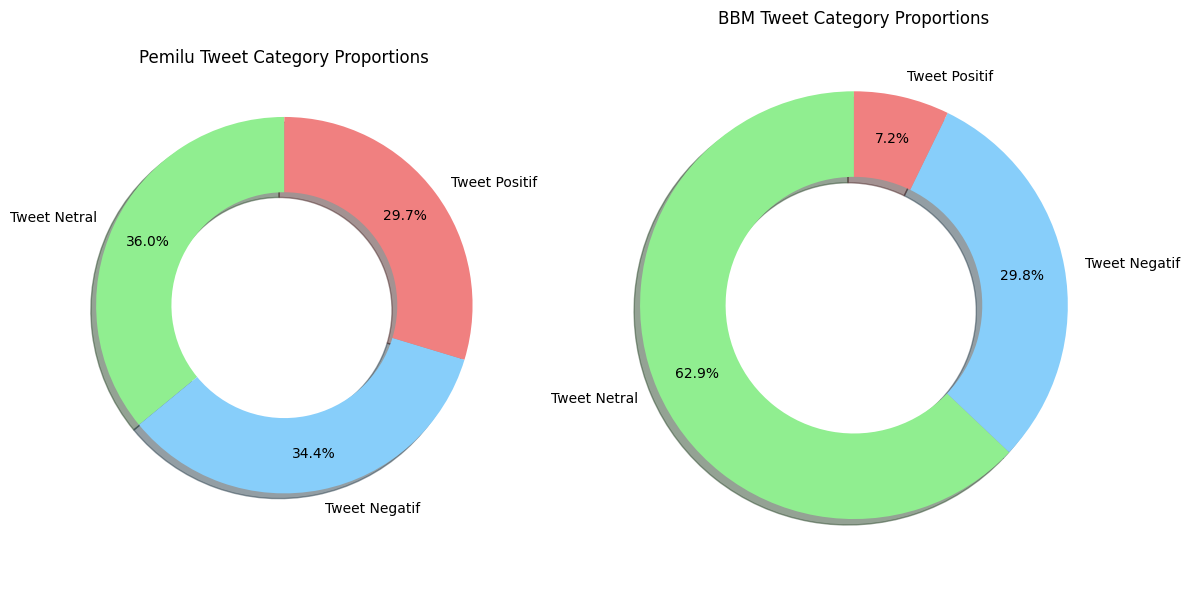

In [8]:
# Membuat Figure dan Axis untuk dua subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot donat untuk Pemilu
donut(sizes_pemilu, ax1, 90, labels_pemilu, colors=colors_pemilu, explode=explode_pemilu, shadow=True)
ax1.set_title('Pemilu Tweet Category Proportions')

# Plot donat untuk BBM
donut(sizes_bbm, ax2, 90, labels_bbm, colors=colors_bbm, explode=explode_bbm, shadow=True)
ax2.set_title('BBM Tweet Category Proportions')

# Menampilkan plot
plt.tight_layout()
plt.show()
     

In [9]:
# 3. Mengecek WordFrequency dan Wordcloud
# Fungsi untuk membuat corpus dari kolom teks
def make_corpus(column):
    corpus_list = [word for text in column for word in text.split(' ')]
    corpus = ' '.join(corpus_list)
    return re.sub(' +', ' ', corpus)  # Mengganti spasi ganda dengan satu spasi

# Fungsi untuk menghitung frekuensi kata
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    df = pd.DataFrame(freqdist.most_common(top), columns=['word', 'freq'])
    return df

In [10]:
# Membuat corpus dan menghitung frekuensi untuk kedua DataFrame
corpus_pemilu = make_corpus(pemilu_df['text'])
corpus_bbm = make_corpus(bbm_df['text'])

corpus_freq_pemilu = word_freq(corpus_pemilu, top=20)
corpus_freq_bbm = word_freq(corpus_bbm, top=20)

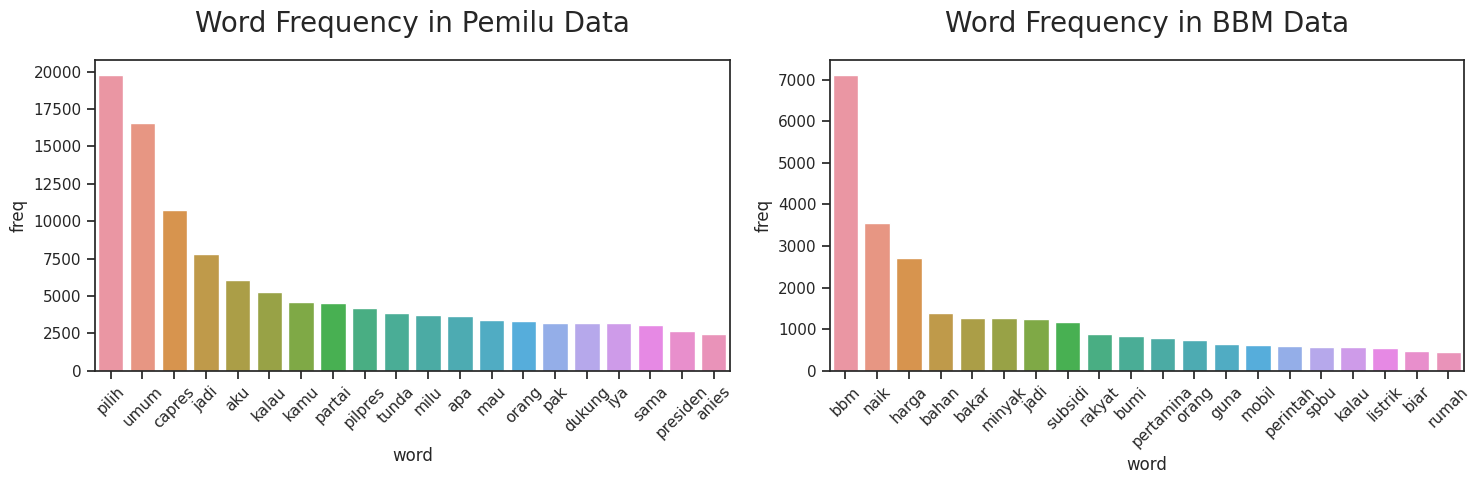

In [11]:
# Mengatur parameter visualisasi
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Membuat figure dengan dua subplot (dua axis)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot frekuensi kata untuk data Pemilu
sns.barplot(x='word', y='freq', data=corpus_freq_pemilu, ax=ax1)
ax1.set_title('Word Frequency in Pemilu Data')
ax1.tick_params(axis='x', rotation=45)

# Plot frekuensi kata untuk data BBM
sns.barplot(x='word', y='freq', data=corpus_freq_bbm, ax=ax2)
ax2.set_title('Word Frequency in BBM Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

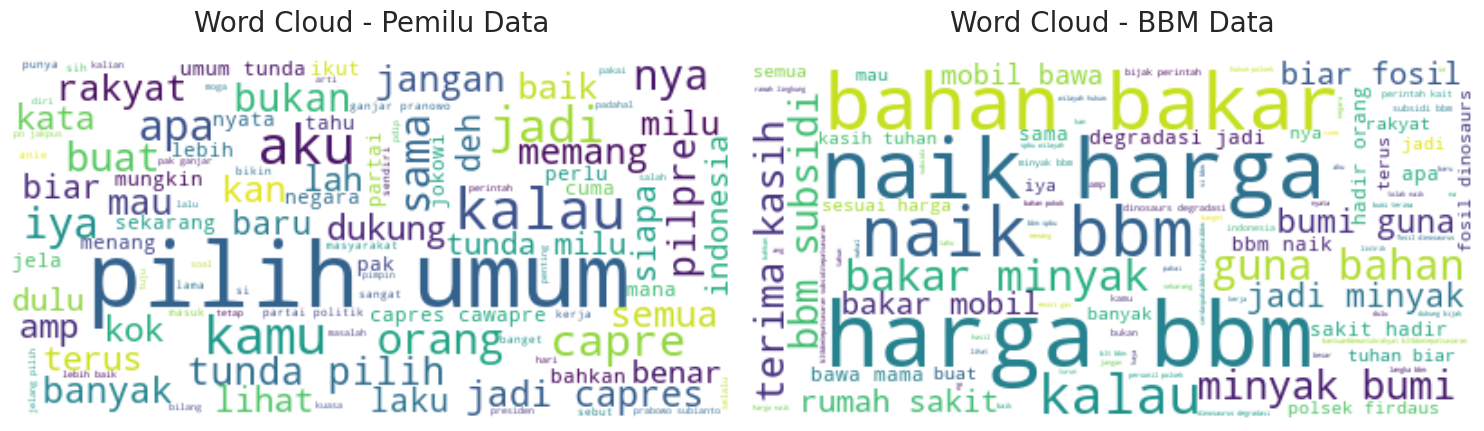

In [12]:
# Membuat WordCloud untuk kedua corpus
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# WordCloud untuk corpus Pemilu
wordcloud_pemilu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_pemilu)
ax1.imshow(wordcloud_pemilu, interpolation="bilinear")
ax1.axis("off")
ax1.set_title('Word Cloud - Pemilu Data')

# WordCloud untuk corpus BBM
wordcloud_bbm = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_bbm)
ax2.imshow(wordcloud_bbm, interpolation="bilinear")
ax2.axis("off")
ax2.set_title('Word Cloud - BBM Data')

plt.tight_layout()
plt.show()

In [13]:
# 4. Mengecek duplikasi value
pemilu_df.duplicated().sum(), bbm_df.duplicated().sum()

(309, 671)

In [14]:
# 5. Menampilkan ukuran baris dan kolom DataFrame
pemilu_df.shape, bbm_df.shape

((42110, 2), (7022, 2))

# Train and Modelling

In [15]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
model = AutoModel.from_pretrained("indolem/indobertweet-base-uncased")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [16]:
# Fungsi untuk menyiapkan dataset dan label
def prepare_dataset_and_labels(dataset):
    all_labels = np.array([dataset[i][1] for i in range(len(dataset))])
    all_texts = [dataset[i][0] for i in range(len(dataset))]
    return all_texts, all_labels

# Fungsi untuk mengukur evaluasi matric
def compute_metrics(preds, labels):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)
    return precision, recall, f1, cm


In [17]:
class DocumentSentimentDataset(torch.utils.data.Dataset):
    LABEL2INDEX = {"neutral": 0, "positive": 1, "negative": 2}

    def __init__(self, dataset_path, tokenizer, lowercase=False):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.lowercase = lowercase

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t')
        df.columns = ['text', 'sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']
        if self.lowercase:
            text = text.lower()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(), sentiment


In [18]:
# Function to plot the history for a given dataset
def plot_history(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall and F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.plot(epochs, history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
    plt.title('Recall and F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [19]:
def save_model_weights(weights, base_filename="model_fold"):
    for i, weight in enumerate(weights):
        filename = f"{base_filename}_{i+1}.pth"
        torch.save(weight, filename)
        print(f"Model weights for Fold {i+1} saved to {filename}")
        

In [20]:
def set_optimizer(model, learning_rates):
    optimizer_grouped_parameters = [
        {"params": model.bert.embeddings.parameters(), "lr": learning_rates['embeddings']},
        {"params": model.bert.encoder.layer[:4].parameters(), "lr": learning_rates['lower_layers']},
        {"params": model.bert.encoder.layer[4:8].parameters(), "lr": learning_rates['middle_layers']},
        {"params": model.bert.encoder.layer[8:].parameters(), "lr": learning_rates['upper_layers']},
        {"params": model.classifier.parameters(), "lr": learning_rates['classifier']},
    ]
    optimizer = optim.AdamW(optimizer_grouped_parameters)
    return optimizer

In [21]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [22]:
def unfreeze_model(model, epoch, n_epochs):
    # Determine the total number of layers in the Roberta encoder
    total_layers = len(list(model.bert.encoder.layer))  # Using 'roberta' instead of 'bert'
    
    if epoch == 0:
        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False
        # Keep the classifier layer unfrozen
        for param in model.classifier.parameters():
            param.requires_grad = True
        print(f"Epoch {epoch+1}: All layers are frozen except the classifier.")
    else:
        # Gradually unfreeze layers based on the epoch
        num_layers_to_unfreeze = int((epoch / n_epochs) * total_layers)
        
        # Unfreeze the desired number of layers
        for i in range(num_layers_to_unfreeze):
            for param in model.bert.encoder.layer[i].parameters():
                param.requires_grad = True
        
        # Print which layers are being unfrozen
        print(f"Epoch {epoch+1}: Unfreezing layers 0 to {num_layers_to_unfreeze - 1}.")
        
        # Ensure remaining layers are still frozen
        for i in range(num_layers_to_unfreeze, total_layers):
            for param in model.bert.encoder.layer[i].parameters():
                param.requires_grad = False
        print(f"Freezing layers {num_layers_to_unfreeze} to {total_layers - 1}.")


In [23]:
def train_and_evaluate_with_modified_architecture(dataset, n_splits=3, n_epochs=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=27)
    history = defaultdict(list)
    model_weights = []

    texts, labels = prepare_dataset_and_labels(dataset)
    oversampler = RandomOverSampler()

    # Use mixed precision training for speedup
    scaler = torch.amp.GradScaler('cuda')
    
    tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

    for fold, (train_idx, valid_idx) in enumerate(skf.split(texts, labels)):
        print(f'Fold {fold + 1}/{n_splits}')
        start_time = time.time()  # Start timing

        # Apply oversampling on the training data
        train_texts_resampled, train_labels_resampled = oversampler.fit_resample(
            np.array(texts)[train_idx], labels[train_idx]
        )
        resampled_dataset = [(torch.tensor(text), label) for text, label in zip(train_texts_resampled, train_labels_resampled)]
        
        train_subset = Subset(resampled_dataset, list(range(len(resampled_dataset))))
        valid_subset = Subset(dataset, valid_idx)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=8, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_subset, batch_size=8, shuffle=False, num_workers=4)

        # Initialize the model only once
        if fold == 0:
            model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3)
            model = model.cuda()

            # Freeze some layers (e.g., freeze all but the last layer)
            for name, param in model.named_parameters():
                if "classifier" not in name:  # Example condition to freeze layers
                    param.requires_grad = False

        optimizer = optim.Adam(model.parameters(), lr=1e-5)
        scheduler = OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_loader), epochs=n_epochs)

        for epoch in range(n_epochs):
            unfreeze_model(model, epoch, n_epochs)  # Unfreeze layers gradually
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
        
            
            model.train()
            total_train_loss = 0
            list_hyp, list_label = [], []

            train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
            for i, (input_ids, sentiment) in enumerate(train_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                optimizer.zero_grad()

                with autocast():  # Mixed precision
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                scheduler.step()  # Update learning rate
                
                total_train_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f}")

            train_metrics = compute_metrics(list_hyp, list_label)
            train_accuracy = accuracy_score(list_label, list_hyp)
            train_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/len(train_loader):.4f} Precision:{train_metrics[0]:.4f} Recall:{train_metrics[1]:.4f} F1-Score:{train_metrics[2]:.4f} Accuracy:{train_accuracy:.4f}")
            print(f"Confusion Matrix:\n{train_conf_matrix}")

            history['train_loss'].append(total_train_loss / len(train_loader))
            history['train_precision'].append(train_metrics[0])
            history['train_recall'].append(train_metrics[1])
            history['train_f1'].append(train_metrics[2])
            history['train_accuracy'].append(train_accuracy)

            # Validation loop
            model.eval()
            total_val_loss = 0
            list_hyp, list_label = [], []

            valid_pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
            for i, (input_ids, sentiment) in enumerate(valid_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                total_val_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                valid_pbar.set_description(f"(Epoch {epoch+1}) VALID LOSS:{total_val_loss/(i+1):.4f}")

            val_metrics = compute_metrics(list_hyp, list_label)
            val_accuracy = accuracy_score(list_label, list_hyp)
            val_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch+1}) VALID LOSS:{total_val_loss/len(valid_loader):.4f} Precision:{val_metrics[0]:.4f} Recall:{val_metrics[1]:.4f} F1-Score:{val_metrics[2]:.4f} Accuracy:{val_accuracy:.4f}")
            print(f"Confusion Matrix:\n{val_conf_matrix}")

            history['val_loss'].append(total_val_loss / len(valid_loader))
            history['val_precision'].append(val_metrics[0])
            history['val_recall'].append(val_metrics[1])
            history['val_f1'].append(val_metrics[2])
            history['val_accuracy'].append(val_accuracy)

        avg_train_loss = np.mean(history['train_loss'])
        avg_val_loss = np.mean(history['val_loss'])
        avg_train_accuracy = np.mean(history['train_accuracy'])
        avg_val_accuracy = np.mean(history['val_accuracy'])

        print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Average Train Accuracy: {avg_train_accuracy:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}')
        
        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Fold {fold + 1} completed in {elapsed_time:.2f} seconds')
        
        # Save the model's weights after the fold
        model_weights.append(model.state_dict())
        
    return history, model_weights


In [24]:
pemilu_dataset = DocumentSentimentDataset('/kaggle/input/dataset-bu-ratih/pemilu_data_preprocessed.tsv', tokenizer, lowercase=True)
bbm_dataset = DocumentSentimentDataset('/kaggle/input/dataset-bu-ratih/bbm_data_preprocessed.tsv', tokenizer, lowercase=True)

In [25]:
%%time 
# Melatih dataset bbm
history_bbm, weights_bbm = train_and_evaluate_with_modified_architecture(bbm_dataset, n_splits=3, n_epochs=3)

Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


  0%|          | 0/1105 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.
(Epoch 1) TRAIN LOSS:1.0540: 100%|██████████| 1105/1105 [01:06<00:00, 16.60it/s]


(Epoch 1) TRAIN LOSS:1.0540 Precision:0.4862 Recall:0.4655 F1-Score:0.4661 Accuracy:0.4655
Confusion Matrix:
[[1134  647 1165]
 [ 397 1521 1028]
 [ 372 1115 1459]]


(Epoch 1) VALID LOSS:0.9784: 100%|██████████| 293/293 [01:04<00:00,  4.54it/s]


(Epoch 1) VALID LOSS:0.9784 Precision:0.7809 Recall:0.6262 F1-Score:0.6755 Accuracy:0.6262
Confusion Matrix:
[[941 305 227]
 [ 11 113  45]
 [ 54 233 412]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.5182: 100%|██████████| 1105/1105 [03:00<00:00,  6.12it/s]


(Epoch 2) TRAIN LOSS:0.5182 Precision:0.8284 Recall:0.8236 F1-Score:0.8236 Accuracy:0.8236
Confusion Matrix:
[[2496  131  319]
 [ 251 2233  462]
 [ 206  190 2550]]


(Epoch 2) VALID LOSS:0.4806: 100%|██████████| 293/293 [01:03<00:00,  4.60it/s]


(Epoch 2) VALID LOSS:0.4806 Precision:0.8570 Recall:0.8261 F1-Score:0.8367 Accuracy:0.8261
Confusion Matrix:
[[1244   81  148]
 [  21  114   34]
 [  38   85  576]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.2717: 100%|██████████| 1105/1105 [03:23<00:00,  5.42it/s]


(Epoch 3) TRAIN LOSS:0.2717 Precision:0.9182 Recall:0.9175 F1-Score:0.9176 Accuracy:0.9175
Confusion Matrix:
[[2628   70  248]
 [ 130 2728   88]
 [ 117   76 2753]]


(Epoch 3) VALID LOSS:0.4414: 100%|██████████| 293/293 [01:03<00:00,  4.59it/s]


(Epoch 3) VALID LOSS:0.4414 Precision:0.8663 Recall:0.8531 F1-Score:0.8570 Accuracy:0.8531
Confusion Matrix:
[[1280   37  156]
 [  22  108   39]
 [  40   50  609]]
Average Train Loss: 0.6146, Average Validation Loss: 0.6335
Average Train Accuracy: 0.7355, Average Validation Accuracy: 0.7685
Fold 1 completed in 645.15 seconds
Fold 2/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.4386: 100%|██████████| 1105/1105 [01:07<00:00, 16.38it/s]


(Epoch 1) TRAIN LOSS:0.4386 Precision:0.8580 Recall:0.8516 F1-Score:0.8509 Accuracy:0.8516
Confusion Matrix:
[[2626   53  267]
 [ 349 2243  354]
 [ 168  121 2657]]


(Epoch 1) VALID LOSS:0.3180: 100%|██████████| 293/293 [01:03<00:00,  4.60it/s]


(Epoch 1) VALID LOSS:0.3180 Precision:0.9205 Recall:0.9060 F1-Score:0.9090 Accuracy:0.9060
Confusion Matrix:
[[1304   57  112]
 [   1  166    2]
 [  22   26  651]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.3268: 100%|██████████| 1105/1105 [03:00<00:00,  6.12it/s]


(Epoch 2) TRAIN LOSS:0.3268 Precision:0.8888 Recall:0.8865 F1-Score:0.8867 Accuracy:0.8865
Confusion Matrix:
[[2574   85  287]
 [ 203 2548  195]
 [ 147   86 2713]]


(Epoch 2) VALID LOSS:0.3164: 100%|██████████| 293/293 [01:03<00:00,  4.59it/s]


(Epoch 2) VALID LOSS:0.3164 Precision:0.9096 Recall:0.8872 F1-Score:0.8918 Accuracy:0.8872
Confusion Matrix:
[[1259   92  122]
 [   2  158    9]
 [  21   18  660]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.1840: 100%|██████████| 1105/1105 [03:23<00:00,  5.42it/s]


(Epoch 3) TRAIN LOSS:0.1840 Precision:0.9449 Recall:0.9443 F1-Score:0.9443 Accuracy:0.9443
Confusion Matrix:
[[2666   40  240]
 [  68 2852   26]
 [  97   21 2828]]


(Epoch 3) VALID LOSS:0.3045: 100%|██████████| 293/293 [01:03<00:00,  4.59it/s]


(Epoch 3) VALID LOSS:0.3045 Precision:0.9101 Recall:0.8966 F1-Score:0.8995 Accuracy:0.8966
Confusion Matrix:
[[1290   65  118]
 [   8  152    9]
 [  27   15  657]]
Average Train Loss: 0.4655, Average Validation Loss: 0.4732
Average Train Accuracy: 0.8148, Average Validation Accuracy: 0.8326
Fold 2 completed in 643.75 seconds
Fold 3/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.2547: 100%|██████████| 1105/1105 [01:07<00:00, 16.38it/s]


(Epoch 1) TRAIN LOSS:0.2547 Precision:0.9200 Recall:0.9176 F1-Score:0.9180 Accuracy:0.9176
Confusion Matrix:
[[2663   54  229]
 [ 107 2667  172]
 [ 138   28 2780]]


(Epoch 1) VALID LOSS:0.1969: 100%|██████████| 293/293 [01:03<00:00,  4.60it/s]


(Epoch 1) VALID LOSS:0.1969 Precision:0.9463 Recall:0.9389 F1-Score:0.9399 Accuracy:0.9389
Confusion Matrix:
[[1344   38   91]
 [   0  169    0]
 [   8    6  684]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.2046: 100%|██████████| 1105/1105 [03:00<00:00,  6.12it/s]


(Epoch 2) TRAIN LOSS:0.2046 Precision:0.9356 Recall:0.9349 F1-Score:0.9349 Accuracy:0.9349
Confusion Matrix:
[[2634   61  251]
 [  54 2840   52]
 [ 111   46 2789]]


(Epoch 2) VALID LOSS:0.1874: 100%|██████████| 293/293 [01:03<00:00,  4.59it/s]


(Epoch 2) VALID LOSS:0.1874 Precision:0.9399 Recall:0.9359 F1-Score:0.9365 Accuracy:0.9359
Confusion Matrix:
[[1357   18   98]
 [   8  159    2]
 [  21    3  674]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.1297: 100%|██████████| 1105/1105 [03:22<00:00,  5.45it/s]


(Epoch 3) TRAIN LOSS:0.1297 Precision:0.9618 Recall:0.9614 F1-Score:0.9613 Accuracy:0.9614
Confusion Matrix:
[[2720   27  199]
 [  21 2919    6]
 [  72   16 2858]]


(Epoch 3) VALID LOSS:0.1945: 100%|██████████| 293/293 [01:03<00:00,  4.60it/s]


(Epoch 3) VALID LOSS:0.1945 Precision:0.9377 Recall:0.9325 F1-Score:0.9333 Accuracy:0.9325
Confusion Matrix:
[[1346   28   99]
 [   8  159    2]
 [  17    4  677]]
Average Train Loss: 0.3758, Average Validation Loss: 0.3798
Average Train Accuracy: 0.8559, Average Validation Accuracy: 0.8670
Fold 3 completed in 642.75 seconds
CPU times: user 32min 7s, sys: 14.4 s, total: 32min 22s
Wall time: 32min 26s


In [26]:
save_model_weights(weights_bbm, base_filename="bbm_model_IndoBERTweet_modified")

Model weights for Fold 1 saved to bbm_model_IndoBERTweet_modified_1.pth
Model weights for Fold 2 saved to bbm_model_IndoBERTweet_modified_2.pth
Model weights for Fold 3 saved to bbm_model_IndoBERTweet_modified_3.pth


In [27]:
%%time 
# Melatih bbm dataset
history_pemilu, weights_pemilu = train_and_evaluate_with_modified_architecture(pemilu_dataset, n_splits=3, n_epochs=3)

Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:1.0927: 100%|██████████| 3786/3786 [03:51<00:00, 16.34it/s]


(Epoch 1) TRAIN LOSS:1.0927 Precision:0.3701 Recall:0.3704 F1-Score:0.3682 Accuracy:0.3704
Confusion Matrix:
[[3486 3645 2964]
 [3317 4569 2209]
 [3258 3675 3162]]


(Epoch 1) VALID LOSS:1.0632: 100%|██████████| 1755/1755 [06:23<00:00,  4.58it/s]


(Epoch 1) VALID LOSS:1.0632 Precision:0.4581 Recall:0.4484 F1-Score:0.4451 Accuracy:0.4484
Confusion Matrix:
[[2296 1701 1051]
 [1281 2315  570]
 [1613 1527 1683]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.9059: 100%|██████████| 3786/3786 [10:20<00:00,  6.10it/s]


(Epoch 2) TRAIN LOSS:0.9059 Precision:0.5797 Recall:0.5819 F1-Score:0.5800 Accuracy:0.5819
Confusion Matrix:
[[4857 2396 2842]
 [1961 6549 1585]
 [2220 1658 6217]]


(Epoch 2) VALID LOSS:0.8636: 100%|██████████| 1755/1755 [06:21<00:00,  4.60it/s]


(Epoch 2) VALID LOSS:0.8636 Precision:0.6164 Recall:0.6097 F1-Score:0.6043 Accuracy:0.6097
Confusion Matrix:
[[2329 1428 1291]
 [ 531 3083  552]
 [ 766  911 3146]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.7873: 100%|██████████| 3786/3786 [11:40<00:00,  5.41it/s]


(Epoch 3) TRAIN LOSS:0.7873 Precision:0.6578 Recall:0.6593 F1-Score:0.6581 Accuracy:0.6593
Confusion Matrix:
[[5796 2054 2245]
 [1626 7335 1134]
 [1995 1263 6837]]


(Epoch 3) VALID LOSS:0.8504: 100%|██████████| 1755/1755 [06:22<00:00,  4.59it/s]


(Epoch 3) VALID LOSS:0.8504 Precision:0.6234 Recall:0.6217 F1-Score:0.6183 Accuracy:0.6217
Confusion Matrix:
[[2539 1243 1266]
 [ 625 2986  555]
 [ 865  756 3202]]
Average Train Loss: 0.9287, Average Validation Loss: 0.9258
Average Train Accuracy: 0.5372, Average Validation Accuracy: 0.5599
Fold 1 completed in 2703.12 seconds
Fold 2/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.8001: 100%|██████████| 3786/3786 [03:50<00:00, 16.40it/s]


(Epoch 1) TRAIN LOSS:0.8001 Precision:0.6498 Recall:0.6509 F1-Score:0.6501 Accuracy:0.6509
Confusion Matrix:
[[5817 2056 2222]
 [1682 7142 1271]
 [2053 1287 6755]]


(Epoch 1) VALID LOSS:0.7525: 100%|██████████| 1755/1755 [06:21<00:00,  4.59it/s]


(Epoch 1) VALID LOSS:0.7525 Precision:0.6805 Recall:0.6785 F1-Score:0.6749 Accuracy:0.6785
Confusion Matrix:
[[2777 1070 1201]
 [ 513 3219  433]
 [ 707  589 3528]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.8014: 100%|██████████| 3786/3786 [10:21<00:00,  6.09it/s]


(Epoch 2) TRAIN LOSS:0.8014 Precision:0.6481 Recall:0.6493 F1-Score:0.6484 Accuracy:0.6493
Confusion Matrix:
[[5783 2080 2232]
 [1693 7126 1276]
 [2016 1323 6756]]


(Epoch 2) VALID LOSS:0.7594: 100%|██████████| 1755/1755 [06:21<00:00,  4.59it/s]


(Epoch 2) VALID LOSS:0.7594 Precision:0.6697 Recall:0.6684 F1-Score:0.6651 Accuracy:0.6684
Confusion Matrix:
[[2750  954 1344]
 [ 568 3073  524]
 [ 723  541 3560]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.7056: 100%|██████████| 3786/3786 [11:40<00:00,  5.40it/s]


(Epoch 3) TRAIN LOSS:0.7056 Precision:0.7013 Recall:0.7026 F1-Score:0.7016 Accuracy:0.7026
Confusion Matrix:
[[6268 1795 2032]
 [1421 7696  978]
 [1746 1034 7315]]


(Epoch 3) VALID LOSS:0.7615: 100%|██████████| 1755/1755 [06:21<00:00,  4.60it/s]


(Epoch 3) VALID LOSS:0.7615 Precision:0.6720 Recall:0.6709 F1-Score:0.6683 Accuracy:0.6709
Confusion Matrix:
[[2833 1051 1164]
 [ 555 3150  460]
 [ 785  604 3435]]
Average Train Loss: 0.8488, Average Validation Loss: 0.8418
Average Train Accuracy: 0.6024, Average Validation Accuracy: 0.6163
Fold 2 completed in 2700.50 seconds
Fold 3/3
Epoch 1: All layers are frozen except the classifier.
Epoch 1/3
Learning rate: 0.000001


(Epoch 1) TRAIN LOSS:0.7351: 100%|██████████| 3786/3786 [03:50<00:00, 16.41it/s]


(Epoch 1) TRAIN LOSS:0.7351 Precision:0.6844 Recall:0.6856 F1-Score:0.6847 Accuracy:0.6856
Confusion Matrix:
[[6129 1799 2168]
 [1512 7504 1080]
 [1832 1131 7133]]


(Epoch 1) VALID LOSS:0.6064: 100%|██████████| 1755/1755 [06:22<00:00,  4.59it/s]


(Epoch 1) VALID LOSS:0.6064 Precision:0.7632 Recall:0.7597 F1-Score:0.7575 Accuracy:0.7597
Confusion Matrix:
[[3285  915  847]
 [ 333 3556  277]
 [ 556  445 3822]]
Epoch 2: Unfreezing layers 0 to 3.
Freezing layers 4 to 11.
Epoch 2/3
Learning rate: 0.000020


(Epoch 2) TRAIN LOSS:0.7472: 100%|██████████| 3786/3786 [10:21<00:00,  6.10it/s]


(Epoch 2) TRAIN LOSS:0.7472 Precision:0.6792 Recall:0.6805 F1-Score:0.6794 Accuracy:0.6805
Confusion Matrix:
[[6061 1875 2160]
 [1513 7493 1090]
 [1847 1193 7056]]


(Epoch 2) VALID LOSS:0.6396: 100%|██████████| 1755/1755 [06:22<00:00,  4.59it/s]


(Epoch 2) VALID LOSS:0.6396 Precision:0.7404 Recall:0.7372 F1-Score:0.7367 Accuracy:0.7372
Confusion Matrix:
[[3522  883  642]
 [ 497 3440  229]
 [ 951  486 3386]]
Epoch 3: Unfreezing layers 0 to 7.
Freezing layers 8 to 11.
Epoch 3/3
Learning rate: 0.000009


(Epoch 3) TRAIN LOSS:0.6326: 100%|██████████| 3786/3786 [11:39<00:00,  5.42it/s]


(Epoch 3) TRAIN LOSS:0.6326 Precision:0.7406 Recall:0.7416 F1-Score:0.7409 Accuracy:0.7416
Confusion Matrix:
[[6789 1486 1821]
 [1233 8103  760]
 [1612  914 7570]]


(Epoch 3) VALID LOSS:0.6286: 100%|██████████| 1755/1755 [06:22<00:00,  4.59it/s]


(Epoch 3) VALID LOSS:0.6286 Precision:0.7418 Recall:0.7407 F1-Score:0.7391 Accuracy:0.7407
Confusion Matrix:
[[3278  912  857]
 [ 451 3432  283]
 [ 694  442 3687]]
Average Train Loss: 0.8009, Average Validation Loss: 0.7695
Average Train Accuracy: 0.6358, Average Validation Accuracy: 0.6595
Fold 3 completed in 2698.93 seconds
CPU times: user 2h 15min 30s, sys: 49.9 s, total: 2h 16min 20s
Wall time: 2h 16min 26s


In [28]:
save_model_weights(weights_pemilu, base_filename="pemilu_model_IndoBERTweet_modified")

Model weights for Fold 1 saved to pemilu_model_IndoBERTweet_modified_1.pth
Model weights for Fold 2 saved to pemilu_model_IndoBERTweet_modified_2.pth
Model weights for Fold 3 saved to pemilu_model_IndoBERTweet_modified_3.pth


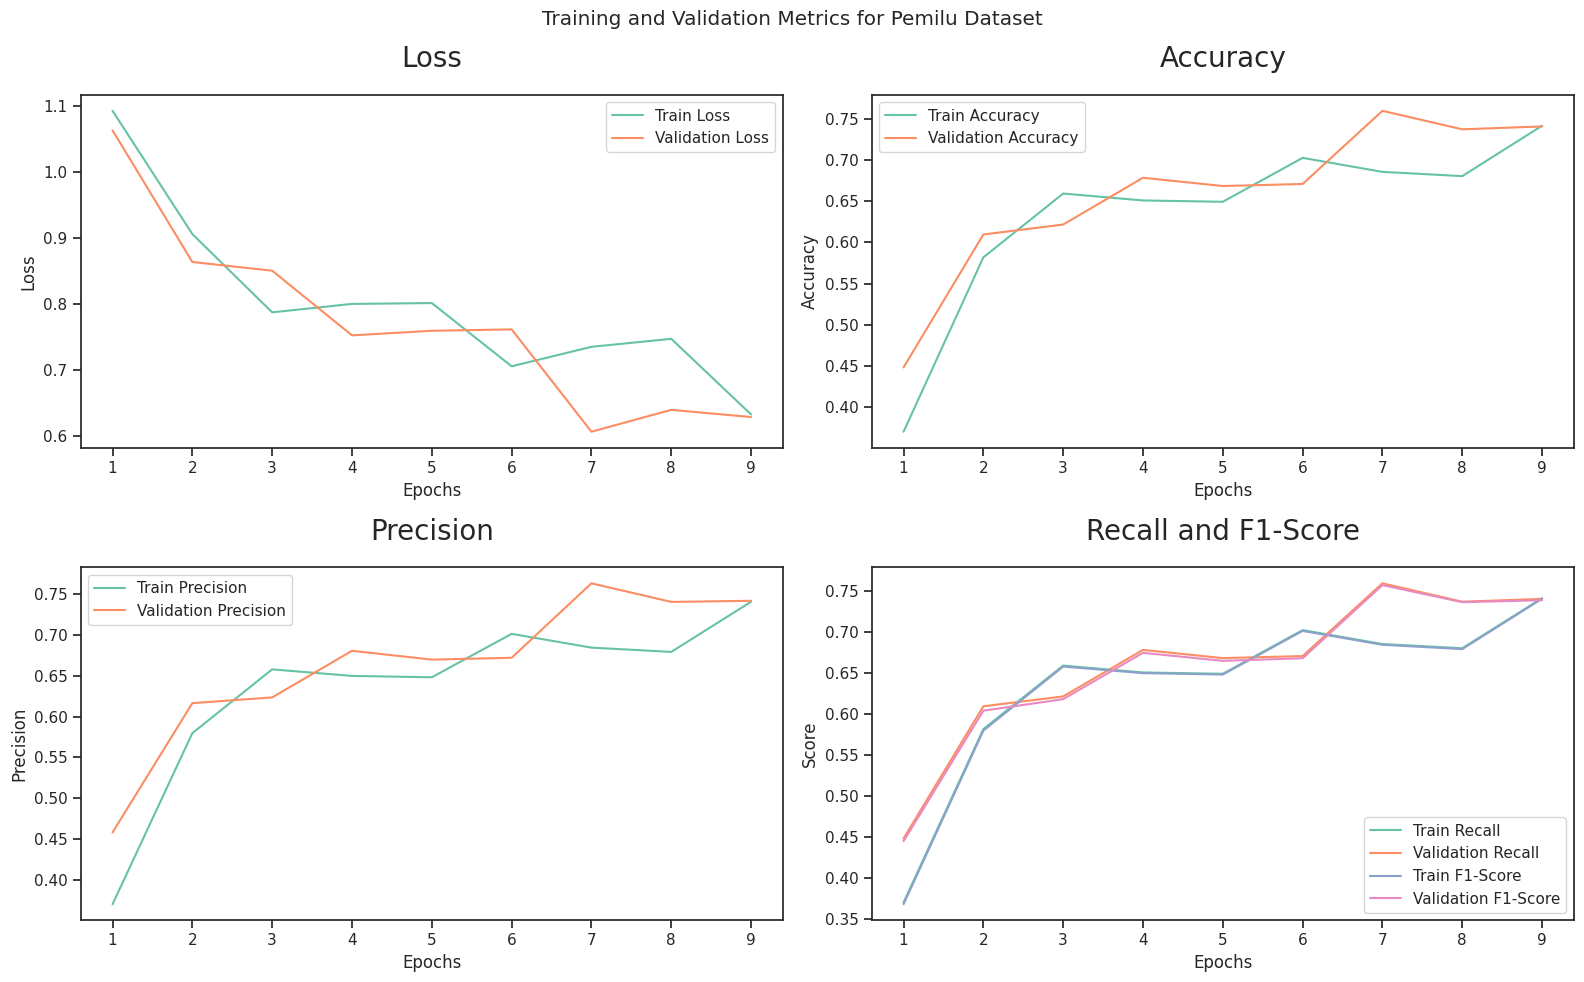

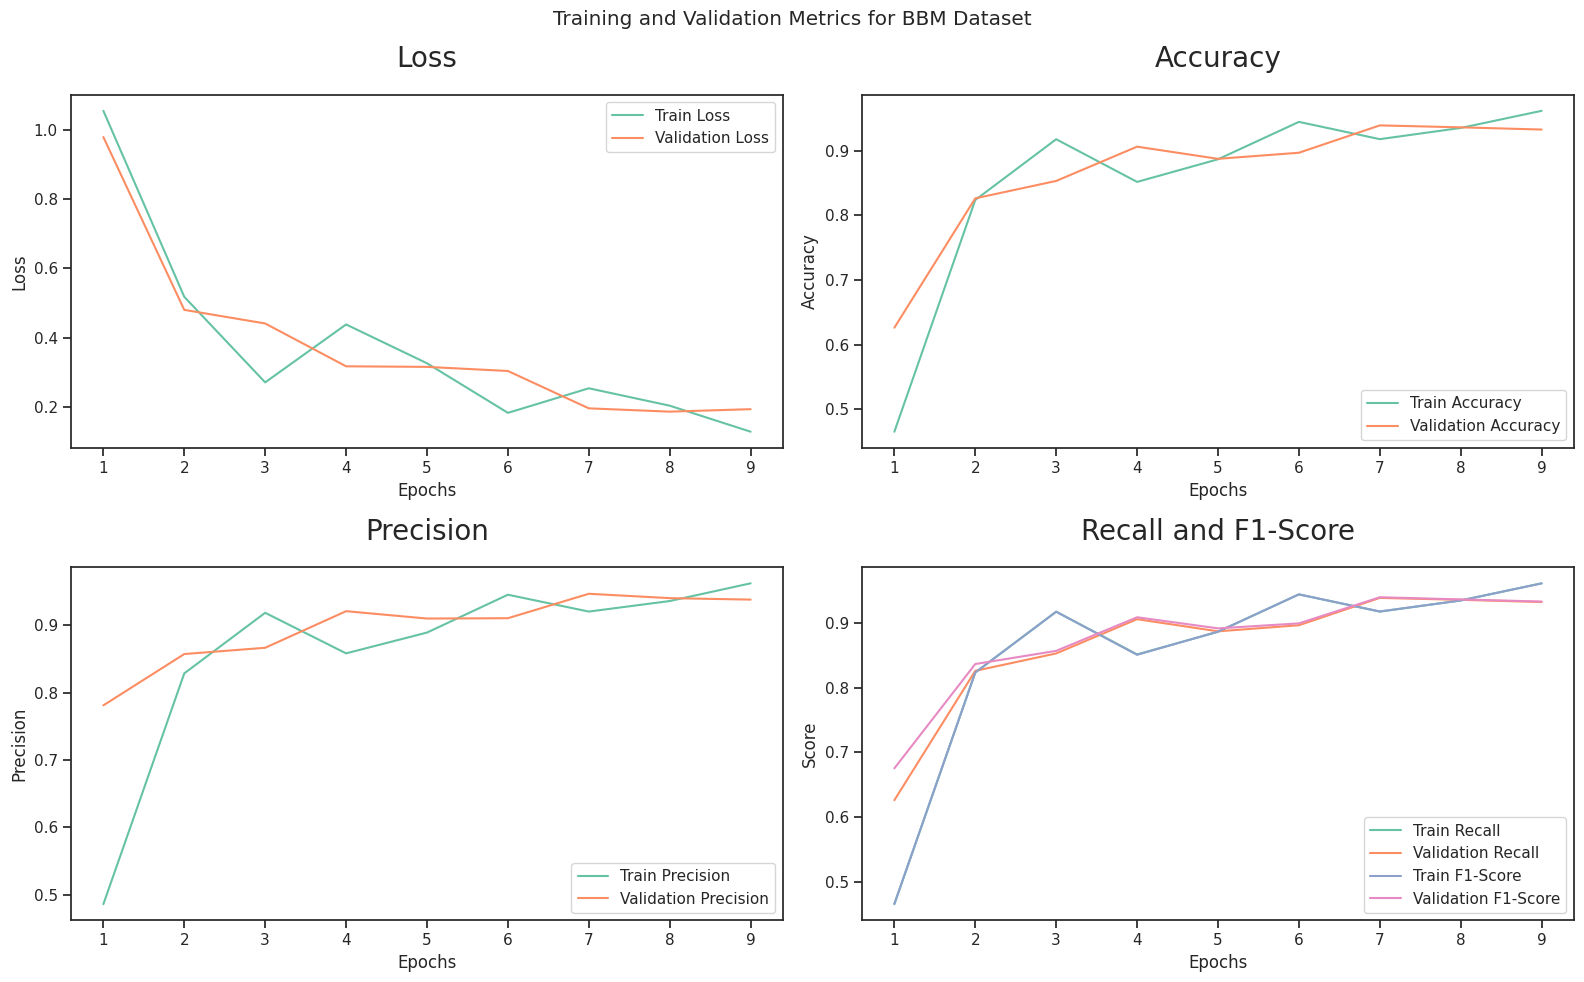

In [29]:
# Plot the history for both datasets
plot_history(history_pemilu, "Training and Validation Metrics for Pemilu Dataset"),
plot_history(history_bbm, "Training and Validation Metrics for BBM Dataset")

# Documentation